# The AirBnB Data Project
## How can we maximize the investment?

In [1]:
#Import Dependencies
import gmaps
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from google import gkey

# Access maps with unique API key
gmaps.configure(api_key=gkey)

## Data Exploration and Cleanup Process

In [2]:
#Reading CSV files
#Load the listings file here: listings_(City Name).csv
#Load the summary file here: summary_(City Name).csv
fullPath = "listings_Berlin.csv"
summPath = "summary_Berlin.csv"

full_df = pd.read_csv(fullPath, encoding="ISO-8859-1")
summ_df = pd.read_csv(summPath, encoding="ISO-8859-1")

In [3]:
#Adjusting DataFrame
new_df = full_df[["id","name","experiences_offered","house_rules","host_id","host_since","host_location","host_response_time","host_response_rate","host_is_superhost","host_listings_count","host_total_listings_count","host_verifications","host_has_profile_pic","host_identity_verified","zipcode","city","state","country","latitude","longitude","is_location_exact","property_type","room_type","accommodates","bathrooms","bedrooms","beds","bed_type","amenities","square_feet","price","weekly_price","monthly_price","security_deposit","cleaning_fee","guests_included","extra_people","minimum_nights","maximum_nights","availability_365","number_of_reviews","number_of_reviews_ltm","review_scores_rating","instant_bookable","cancellation_policy","require_guest_profile_picture","require_guest_phone_verification","reviews_per_month"]]
airbnb_df = pd.merge(new_df,summ_df,how = "left",on = "id")
airbnb_df["Occupancy"] = 365 - airbnb_df["availability_365_y"]

#---------------------------Ending of principal Branch----------------------------------------

In [4]:
#Cleaning Zip Codes
#airbnb_df['zipcode'].replace([' '], '0')
def fix_zip_codes(zips):
  weird_zips = zips == "13359 Berlin, 13187 Pankow, 10997 Kreuzberg, 10777 Berlin, z. B 13351, 10247, friedrichshain, 1043"
  zips[weird_zips] = np.nan
  weird_zips = (zips == "10115010115") | (zips == "10969010969") | (zips == "10119010119")
  zips[weird_zips] = np.nan
  zips = zips.str.lstrip("CP ")

  return zips

## Airbnb Occupancy General Analysis

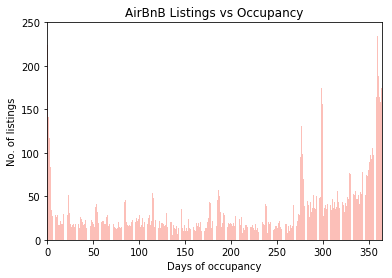

In [5]:
#AIRBNB LISTINGS VS OCCUPANCY
occup_revision = airbnb_df[["Occupancy","id"]]
occup_revision = occup_revision.sort_values("Occupancy", ascending = False)
grouped_by_occup = occup_revision.groupby(['Occupancy'])

tot_occup_df = pd.DataFrame(grouped_by_occup["id"].count())
tot_occup_df = tot_occup_df.reset_index()
tot_occup_df.columns = ['Occupancy', 'counts']
tot_occup_df.drop([365],inplace = True)

plt.bar(tot_occup_df["Occupancy"], tot_occup_df["counts"], color='salmon', alpha=0.5, align="edge")

plt.xlim(0, 364)
plt.ylim(0, 250)


plt.title("AirBnB Listings vs Occupancy")
plt.xlabel("Days of occupancy")
plt.ylabel("No. of listings")
plt.savefig("ListingsvsOccupancy.png")
plt.show()

In [6]:
size_bins = [0, 121, 243, 365]
group_names = ["Low (<121)", "Medium (121-243)", "High (243-365)"]
occup_summ = airbnb_df
occup_summ["Occupancy rate"]=pd.cut(occup_summ["Occupancy"], size_bins, labels=group_names)
occup_related = occup_summ[["Occupancy rate","Occupancy"]]
occup_related_g = occup_related.groupby("Occupancy rate")
occup_related_g.mean()   #Average occupancy by bin

,Occupancy
Occupancy rate,
Low (<121),54.324269
Medium (121-243),184.090164
High (243-365),349.273690


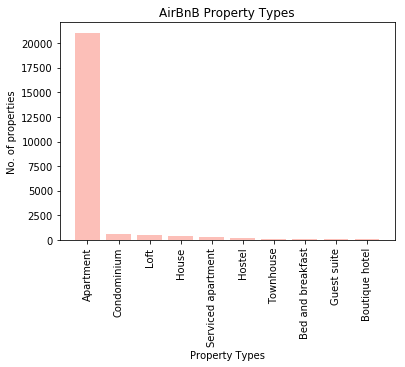

In [7]:
#BAR PLOT PROPERTY TYPE VS NUMBER OF LISTINGS
table_pr_types = pd.DataFrame(airbnb_df["property_type"].value_counts())
table_pr_types = table_pr_types.reset_index()
table_pr_types.columns = ['property_type', 'counts']
table_summ = table_pr_types.head(10)
x_axis = np.arange(len(table_summ))
tick_locations = [value+0.4 for value in x_axis]
plt.bar(x_axis, table_summ["counts"], color='salmon', alpha=0.5, align="edge")
plt.xticks(tick_locations, table_summ["property_type"], rotation="vertical")

plt.title("AirBnB Property Types")
plt.xlabel("Property Types")
plt.ylabel("No. of properties")
plt.savefig("PropertyTypeAnalysis.png")
plt.show()

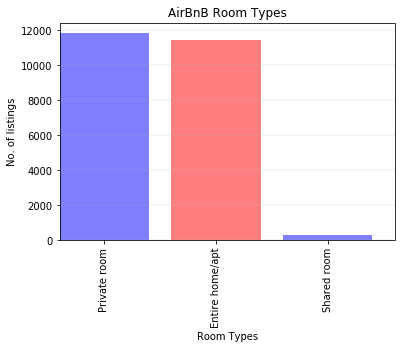

In [8]:
#ROOM TYPE ANALYSIS
occup_summ = airbnb_df
t_room_type = pd.DataFrame(occup_summ["room_type_x"].value_counts())
t_room_type = t_room_type.reset_index()
t_room_type.columns = ['room_type', 'counts']
t_room_type

def pltcolor(lst):
    cols2=[]
    for l in lst:
        if l=='Private room':
            cols2.append('red')
        elif l=='Entire home/apt':
            cols2.append('blue')
        else:
            cols2.append('green')
    return cols2
# Create the colors list using the function above
cols2=pltcolor(airbnb_df["room_type_x"])

plt.bar(t_room_type["room_type"], t_room_type["counts"], color=cols2, alpha=0.5, align="edge")
plt.xticks(tick_locations, t_room_type["room_type"], rotation="vertical")
plt.xlim(0, 3)

plt.title("AirBnB Room Types")
plt.xlabel("Room Types")
plt.ylabel("No. of listings")
plt.grid(axis='y',linewidth=0.25)
plt.savefig("RoomTypeAnalysis.png")

plt.show()

## Deep Analysis of Room Types (Price, Occupancy)

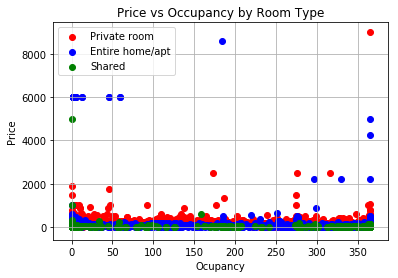

In [9]:
##---H---
plt.figure()

#Function to define color for the plots
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l=='Private room':
            cols.append('red')
        elif l=='Entire home/apt':
            cols.append('blue')
        else:
            cols.append('green')
    return cols

# Create the colors list using the function above
cols=pltcolor(airbnb_df["room_type_x"])

#Filtering information and then grouping it
airbnb_entire = airbnb_df.loc[(airbnb_df["room_type_x"] == "Entire home/apt"),:]
airbnb_private = airbnb_df.loc[(airbnb_df["room_type_x"] == "Private room"),:]
airbnb_shared = airbnb_df.loc[(airbnb_df["room_type_x"] == "Shared room"),:]

plt.scatter(airbnb_entire['Occupancy'],airbnb_entire['price_x'], c='red')
plt.scatter(airbnb_private['Occupancy'],airbnb_private['price_x'], c='blue')
plt.scatter(airbnb_shared['Occupancy'],airbnb_shared['price_x'], c='green')

plt.grid()
plt.title("Price vs Occupancy by Room Type")
plt.xlabel('Ocupancy')
plt.ylabel('Price')

plt.legend(['Private room','Entire home/apt','Shared'])

# Save Figure
plt.savefig("Price_vs_Occupancy_by_room_type.png")

# Show Figure
plt.show()

In [10]:
#Percentage of Private Rooms booked
private_room = airbnb_df.loc[ (airbnb_df["room_type_x"] == "Private room"), : ]
#len(private_room)
private_room_365 = private_room.loc[ (airbnb_df["Occupancy"] == 365), : ]
#len(private_room_365)

occupancy_percentage_pr = round(np.divide(len(private_room_365), len(private_room))*100,2)
print(str(occupancy_percentage_pr) + "% of Private Rooms are fully booked")


#Percentage of Entire Rooms booked
entire_room = airbnb_df.loc[ (airbnb_df["room_type_x"] == "Entire home/apt"), : ]
#len(entire_room)

entire_room_365 = entire_room.loc[ (airbnb_df["Occupancy"] == 365), : ]
#len(entire_room_365)

occupancy_percentage_er = round(np.divide(len(entire_room_365), len(entire_room))*100,2)
print(str(occupancy_percentage_er) + "% of Entire Rooms are fully booked")


#Percentage of Shared Rooms booked
shared_room = airbnb_df.loc[ (airbnb_df["room_type_x"] == "Shared room"), : ]
#len(shared_room)

shared_room_365 = shared_room.loc[ (airbnb_df["Occupancy"] == 365), : ]
#len(shared_room_365)

occupancy_percentage_sr = round(np.divide(len(shared_room_365), len(shared_room))*100,2)
print(str(occupancy_percentage_sr) + "% of Shared Rooms are fully booked")


52.37% of Private Rooms are fully booked
44.1% of Entire Rooms are fully booked
37.46% of Shared Rooms are fully booked


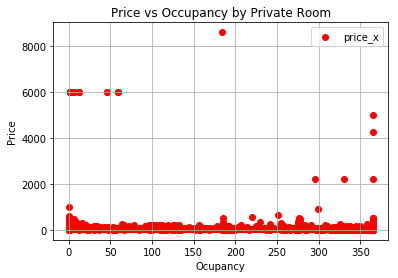

In [11]:
plt.scatter(private_room['Occupancy'],private_room['price_x'], c="red")
plt.grid()
plt.xlabel('Ocupancy')
plt.ylabel('Price')
plt.title("Price vs Occupancy by Private Room")
plt.legend()
# Save Figure
plt.savefig("Price_vs_Occupancy_by_private_room.png")
# Show Figure
plt.show()

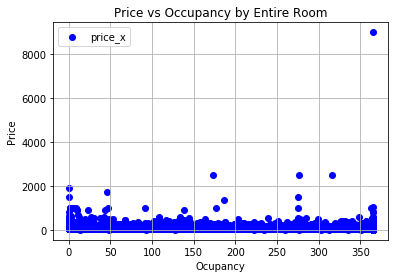

In [12]:
plt.scatter(entire_room['Occupancy'],entire_room['price_x'], c="blue")
plt.grid()
plt.title("Price vs Occupancy by Entire Room")
plt.xlabel('Ocupancy')
plt.ylabel('Price')
plt.legend()
plt.savefig("Price_vs_Occupancy_by_entire_room.png")
plt.show()

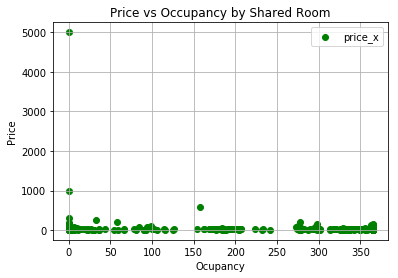

In [13]:
plt.scatter(shared_room['Occupancy'],shared_room['price_x'], c="green")
plt.grid()
plt.xlabel('Ocupancy')
plt.ylabel('Price')
plt.title("Price vs Occupancy by Shared Room")
plt.ylim=(0,1000)
plt.legend()
plt.savefig("Price_vs_Occupancy_by_shared_room.png")
plt.show()

C:\Users\xvazquez\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


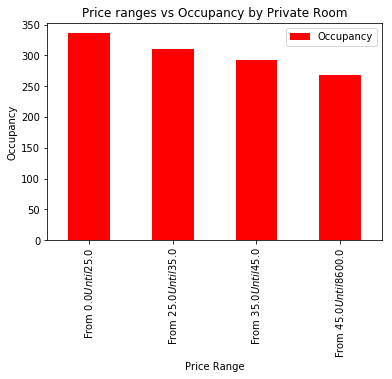

In [14]:
#Bins
pr_bins = [private_room.price_x.quantile(0.00),
            private_room.price_x.quantile(0.25),
            private_room.price_x.quantile(0.50),
            private_room.price_x.quantile(0.75),
            private_room.price_x.quantile(1.00)]

pr_labels = ["From $" + str(private_room.price_x.quantile(0.0)) + "Until $" + str(private_room.price_x.quantile(0.25)),
            "From $" + str(private_room.price_x.quantile(0.25)) +  "Until $" + str(private_room.price_x.quantile(0.50)),
            "From $" + str(private_room.price_x.quantile(0.50)) +  "Until $"+ str(private_room.price_x.quantile(0.75)),
            "From $"+ str(private_room.price_x.quantile(0.75)) +  "Until $"+str(private_room.price_x.quantile(1.00)),]

pd.cut(private_room["price_x"], pr_bins, labels=pr_labels) 
private_room["Range"] = pd.cut(private_room["price_x"], pr_bins, labels=pr_labels) 

grouped_pr_ranges = private_room.groupby("Range").mean()
grouped_pr_ranges_by_price = grouped_pr_ranges[["Occupancy"]]

grouped_pr_ranges_by_price.plot(kind="bar", facecolor="red")
plt.ylabel('Occupancy')
plt.xlabel('Price Range')
plt.title("Price ranges vs Occupancy by Private Room")

plt.savefig("Price_ranges_vs_Occupancy_by_private_room.png")
plt.show()

C:\Users\xvazquez\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


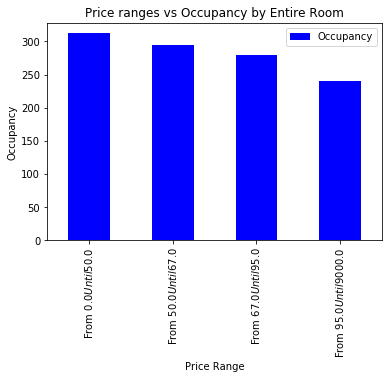

In [15]:
er_bins = [entire_room.price_x.quantile(0.00),
            entire_room.price_x.quantile(0.25),
            entire_room.price_x.quantile(0.50),
            entire_room.price_x.quantile(0.75),
            entire_room.price_x.quantile(1.00)]

er_labels = ["From $" + str(entire_room.price_x.quantile(0.0)) + "Until $" + str(entire_room.price_x.quantile(0.25)),
            "From $" + str(entire_room.price_x.quantile(0.25)) +  "Until $" + str(entire_room.price_x.quantile(0.50)),
            "From $" + str(entire_room.price_x.quantile(0.50)) +  "Until $"+ str(entire_room.price_x.quantile(0.75)),
            "From $"+ str(entire_room.price_x.quantile(0.75)) +  "Until $"+str(entire_room.price_x.quantile(1.00)),]

pd.cut(entire_room["price_x"], er_bins, labels=er_labels)  

entire_room["Range"] = pd.cut(entire_room["price_x"], er_bins, labels=er_labels) 

grouped_er_ranges = entire_room.groupby("Range").mean()
grouped_er_ranges_by_price = grouped_er_ranges[["Occupancy"]]

grouped_er_ranges_by_price.plot(kind="bar", facecolor="blue")
plt.ylabel('Occupancy')
plt.xlabel('Price Range')
plt.title("Price ranges vs Occupancy by Entire Room")
plt.savefig("Price_ranges_vs_Occupancy_by_entire_room.png")
plt.show()

C:\Users\xvazquez\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


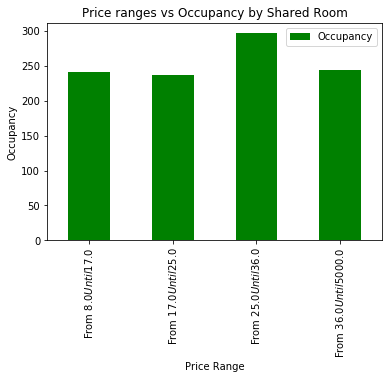

In [16]:
sr_bins = [shared_room.price_x.quantile(0.00),
            shared_room.price_x.quantile(0.25),
            shared_room.price_x.quantile(0.50),
            shared_room.price_x.quantile(0.75),
            shared_room.price_x.quantile(1.00)]

sr_labels = ["From $" + str(shared_room.price_x.quantile(0.0)) + "Until $" + str(shared_room.price_x.quantile(0.25)),
                "From $" + str(shared_room.price_x.quantile(0.25)) +  "Until $" + str(shared_room.price_x.quantile(0.50)),
                "From $" + str(shared_room.price_x.quantile(0.50)) +  "Until $"+ str(shared_room.price_x.quantile(0.75)),
                "From $"+ str(shared_room.price_x.quantile(0.75)) +  "Until $"+str(shared_room.price_x.quantile(1.00)),]

pd.cut(shared_room["price_x"], sr_bins, labels=sr_labels)  

shared_room["Range"] = pd.cut(shared_room["price_x"], sr_bins, labels=sr_labels) 

grouped_sr_ranges = shared_room.groupby("Range").mean()
grouped_sr_ranges_by_price = grouped_sr_ranges[["Occupancy"]]

grouped_sr_ranges_by_price.plot(kind="bar", facecolor="green")
plt.ylabel('Occupancy')
plt.xlabel('Price Range')
plt.title("Price ranges vs Occupancy by Shared Room")
plt.savefig("Price_ranges_vs_Occupancy_by_shared_room.png")
plt.show()

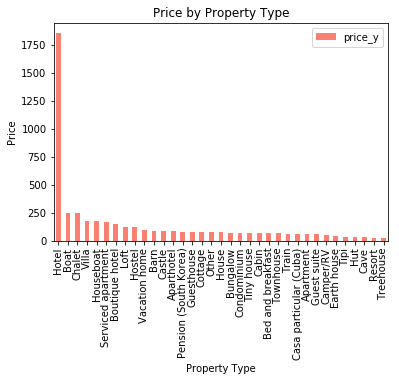

<Figure size 432x288 with 0 Axes>

In [17]:
#Price VS Property Type
priceVSproperty= airbnb_df[["price_y", "property_type"]]
priceVSproperty.dropna(axis=0, how='all')
prop_type= priceVSproperty.groupby('property_type').mean()

prop_type = prop_type.sort_values("price_y", ascending = False)

property_chart = prop_type.plot(kind="bar", color= "salmon", title="Price by Property Type")
property_chart.set_xlabel("Property Type")
property_chart.set_ylabel("Price")


occup_revision = occup_revision.sort_values("Occupancy", ascending = False)

plt.show()
plt.tight_layout()
plt.savefig("Price_vs_Property_type.png")

C:\Users\xvazquez\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


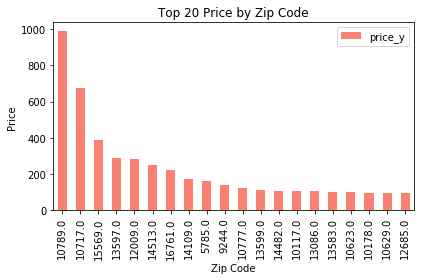

<Figure size 432x288 with 0 Axes>

In [18]:
#Price VS Zip Code
priceVSzip= airbnb_df[["price_y", "zipcode"]]
#priceVSzip["zipcode"] = fix_zip_codes(priceVSzip["zipcode"])
priceVSzip.dropna(inplace=True)

zip_code = priceVSzip.groupby('zipcode').mean()
zip_code_g = zip_code[['price_y']]

zip_code_m = zip_code_g.sort_values("price_y", ascending = False)
zip_code_r = zip_code_m.head(20)
zipcode_chart = zip_code_r.plot(kind="bar", color= "salmon", title="Top 20 Price by Zip Code")
zipcode_chart.set_xlabel("Zip Code")
zipcode_chart.set_ylabel("Price")
plt.tight_layout()
plt.show()
plt.savefig("Top_20_Price_vs_Zipcode.png")

C:\Users\xvazquez\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


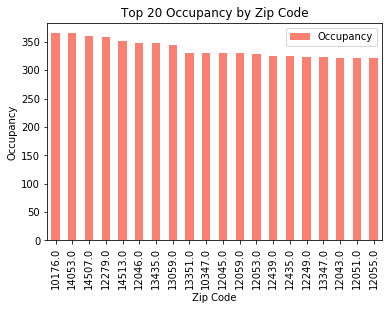

<Figure size 432x288 with 0 Axes>

In [19]:
#Occupancy VS Zip Code
occupancyVSzip= airbnb_df[["Occupancy", "zipcode"]]
occupancyVSzip.dropna(inplace=True)
#occupancyVSzip["zipcode"] = fix_zip_codes(occupancyVSzip["zipcode"])

#Occupancy VS Zip Code chart
occupancy_zip_code = occupancyVSzip.groupby('zipcode').mean()
occupancy_zip_code_g = occupancy_zip_code[['Occupancy']]

zip_code_om = occupancy_zip_code_g.sort_values("Occupancy", ascending = False)
zip_code_or = zip_code_om.head(20)
occupancy_zipcode_chart = zip_code_or.plot(kind="bar", color= "salmon", title="Top 20 Occupancy by Zip Code")
occupancy_zipcode_chart.set_xlabel("Zip Code")
occupancy_zipcode_chart.set_ylabel("Occupancy")

plt.show()
plt.tight_layout()
plt.savefig("Occupancy_vs_zipcode.png")

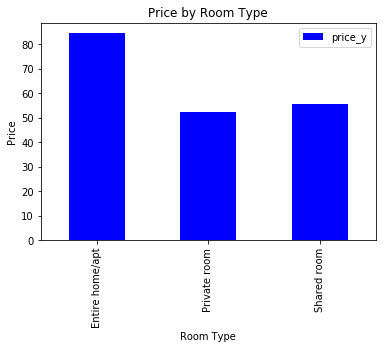

<Figure size 432x288 with 0 Axes>

In [20]:
#Price VS Room Type
priceVSroomty= airbnb_df[["price_y", "room_type_y"]]
priceVSroomty.dropna(axis=0, how='all')
room_type= priceVSroomty.groupby('room_type_y').mean()
room_chart = room_type.plot(kind="bar", color= cols, title="Price by Room Type")
room_chart.set_xlabel("Room Type")
room_chart.set_ylabel("Price")

plt.show()
plt.tight_layout()
plt.savefig("Price_vs_Room_Type.png")

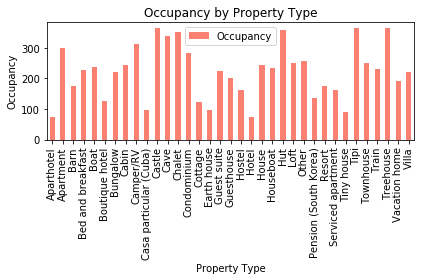

<Figure size 432x288 with 0 Axes>

In [21]:
#Occupancy VS Property Type
ocVSproperty= airbnb_df[["Occupancy", "property_type"]]
ocVSproperty.dropna(axis=0, how='all')
occupancy_prop_type= ocVSproperty.groupby('property_type').mean()
#occupancy_prop_type= ocVSproperty.groupby('property_type')
occupancy_prop_type.round()
occupancy_property_chart = occupancy_prop_type.plot(kind="bar", color= "salmon", title="Occupancy by Property Type")
occupancy_property_chart.set_xlabel("Property Type")
occupancy_property_chart.set_ylabel("Occupancy")
plt.tight_layout()
plt.show()

plt.savefig("Occupancy_vs_ProperType.png")

## Other factors that influence the occupancy. Ratings and Amenities

C:\Users\xvazquez\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


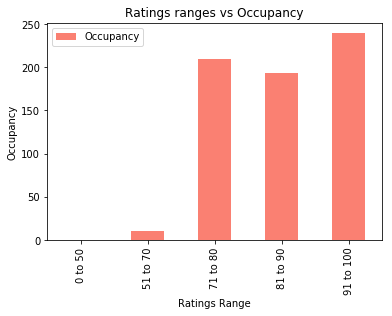

In [22]:
airbnb_df = pd.merge(summ_df,new_df,how = "left",on = "id")
airbnb_df["Occupancy"]=365 - airbnb_df["availability_365_y"]

more_than_20 = airbnb_df.loc[ (airbnb_df["number_of_reviews_x"] > 20), : ]

rr_bins = [0,50,70,80,90,100]
rr_labels = ["0 to 50", "51 to 70", "71 to 80", "81 to 90", "91 to 100"]

pd.cut(more_than_20["review_scores_rating"], rr_bins, labels=rr_labels)

more_than_20["Ratings Range"] = pd.cut(more_than_20["review_scores_rating"], rr_bins, labels=rr_labels)

grouped_rr_ranges = more_than_20.groupby("Ratings Range").mean()
grouped_rr_ranges_by_occu = grouped_rr_ranges[["Occupancy"]]
grouped_rr_ranges_by_occu.plot(kind="bar", facecolor="salmon")

plt.ylabel('Occupancy')
plt.title("Ratings ranges vs Occupancy")
plt.savefig("Ratings_ranges_vs_Occupancy.png")
plt.show()

In [23]:
my_columns = ["id","name_x","price_x","weekly_price","monthly_price","Occupancy","amenities","experiences_offered","property_type","room_type_x","accommodates","bathrooms","bedrooms","beds","bed_type"]
amenities_airbnb_df = airbnb_df[my_columns]
amenities_arr = amenities_airbnb_df["amenities"].values

amen_lst = []
for amenity_list in amenities_arr:
    provis = amenity_list.replace("{","")
    provis = provis.replace("}","")
    provis = provis.replace("'","")
    provis = provis.replace('"',"")
    amen_lst.append(provis)

In [24]:
amenities_dict = {}

amen_index = 0
for airbnb in amenities_airbnb_df["id"]:
    amenities_dict[airbnb]=amen_lst[amen_index].split(",")
    amen_index = amen_index + 1    

In [25]:
#Remove amenities listed as "translation missing"
cleaned_amenities_dict = {}
amen_index = 0
for airbnb in amenities_airbnb_df["id"]:
   cleaned_amenities_dict[airbnb]=[ x for x in amenities_dict[airbnb] if "translation missing" not in x ]
   amen_index = amen_index + 1

In [26]:
all_amenities = []
amen_index=0
for airbnb in amenities_airbnb_df["id"]:
    all_amenities = all_amenities + cleaned_amenities_dict[amenities_airbnb_df["id"][amen_index]]
    amen_index = amen_index + 1

In [27]:
amenities_set = set(all_amenities)
unique_amen_list = list(amenities_set)
amenity_tally = []
for element in unique_amen_list:
    amenity_tally.append(all_amenities.count(element))

In [28]:
top_amen_dict = {
    "amenity": unique_amen_list,
    "amenity_tally":amenity_tally
}

In [29]:
top_amen_df = pd.DataFrame(top_amen_dict)
descending_top_amen_df = top_amen_df.sort_values(["amenity_tally"],ascending=False)
%matplotlib notebook

<IPython.core.display.Javascript object>


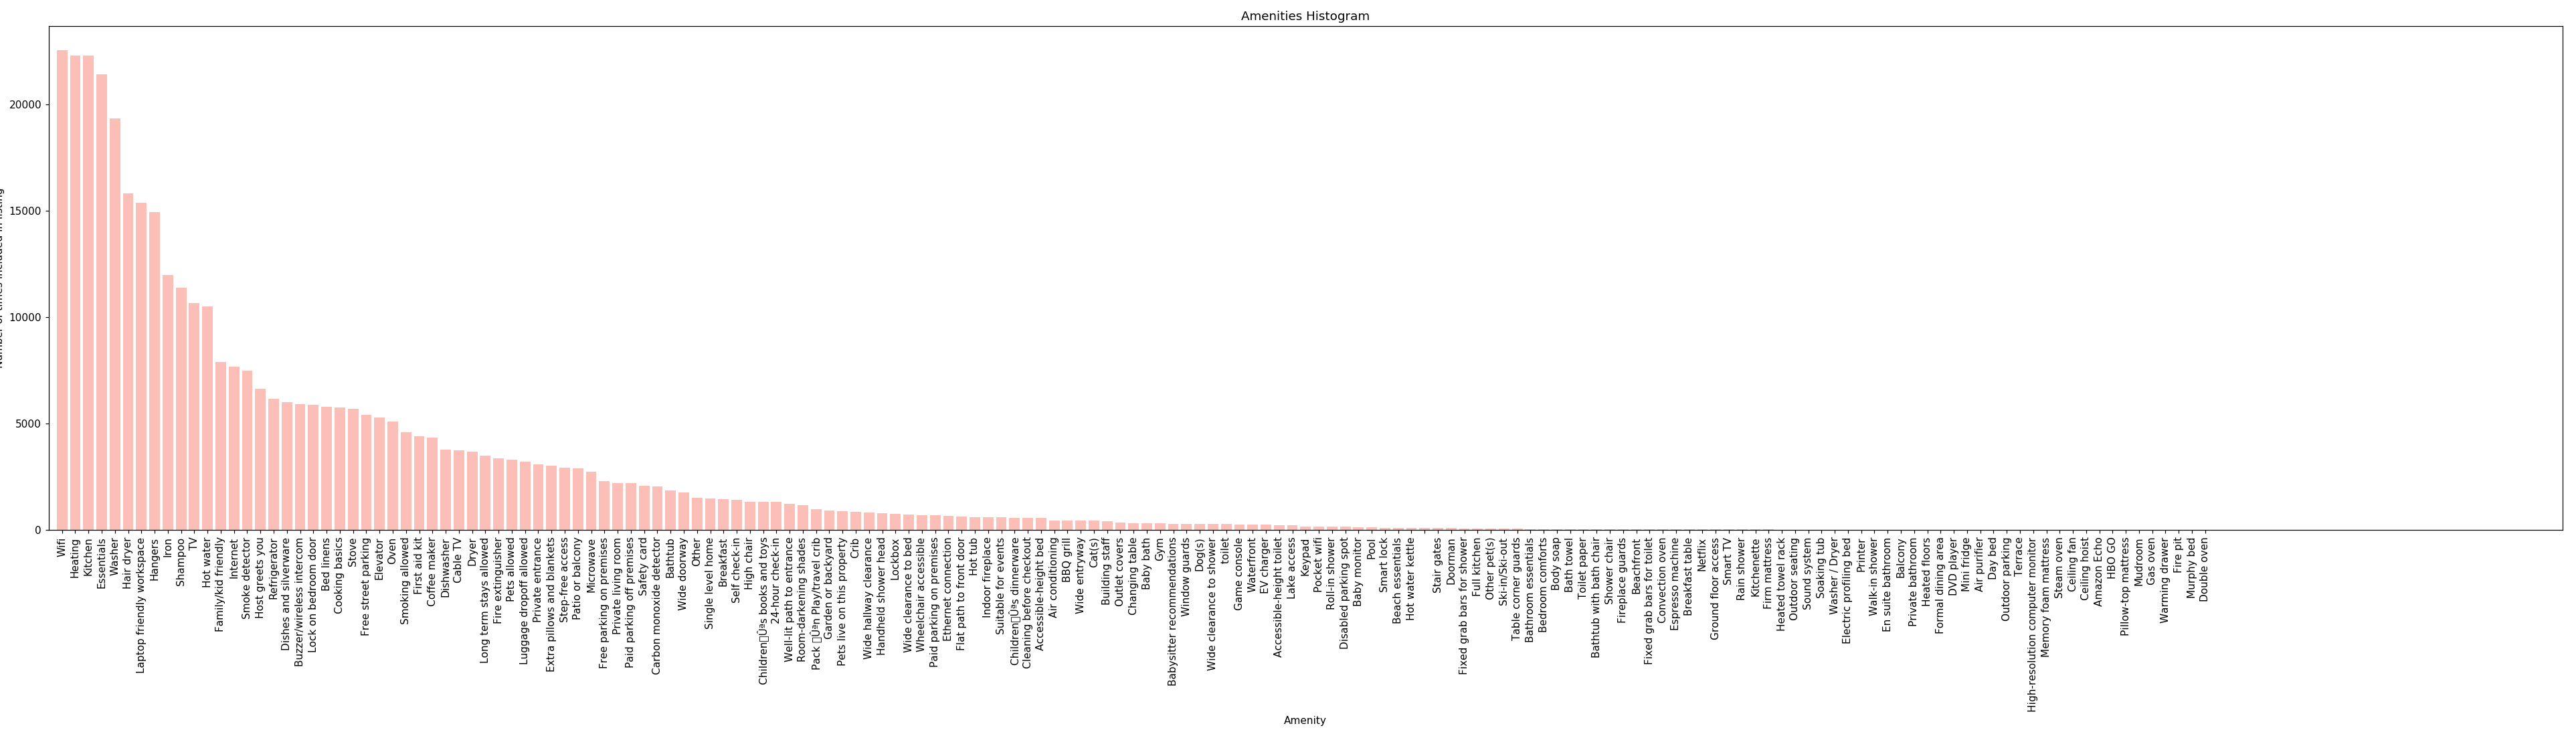

In [30]:
# Set x axis and tick locations
x_axis = np.arange(1,descending_top_amen_df["amenity"].count()+1,1)
tick_locations = x_axis

#yaxis
tally_data = list(descending_top_amen_df["amenity_tally"])

# Create a list indicating where to write x labels and set figure size to adjust for space
x_labels = np.array(descending_top_amen_df["amenity"])

plt.figure(figsize=(35,10))
plt.xticks(tick_locations,x_labels,rotation = 90)
plt.xlim(0,190)
plt.xlabel("Amenity")
plt.ylabel("Number of times included in listing")
plt.title("Amenities Histogram")
plt.tight_layout()
plt.savefig("Amenities_Histogram.png")
plt.bar(x_axis,tally_data,color = 'salmon',alpha = 0.5)
plt.show()

C:\Users\xvazquez\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<IPython.core.display.Javascript object>


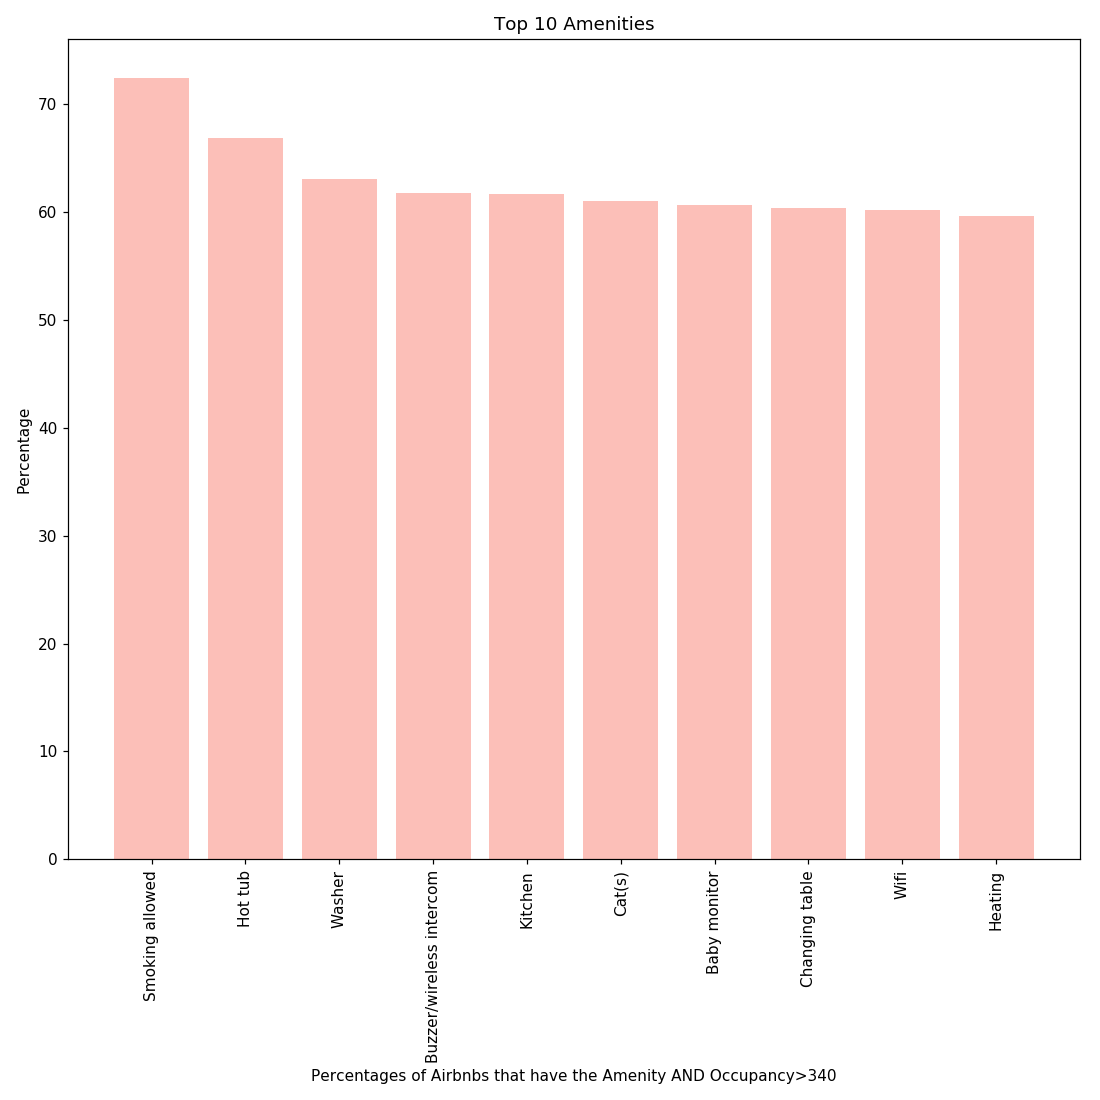

In [35]:
top100 = []
%matplotlib notebook
for index in range(100):
    top100.append(list(descending_top_amen_df["amenity"])[index])
    
top100.remove("Internet")    

some_columns = ["id","Occupancy"]

d=amenities_airbnb_df.reset_index()

perc_df = d[some_columns]

perc_df["amenities"] = amen_lst

perc_df_greater_340 = perc_df.loc[perc_df["Occupancy"]>=340]

counts = []
for amenity in top100:
    count = 0
    for lst in range(len(perc_df)):
        if amenity in perc_df["amenities"][lst].split(","):
            count = count + 1
    counts.append(count)

counts_greater_than = []
my_df = perc_df_greater_340.reset_index()
for amenity in top100:
    count = 0
    for lst in range(len(perc_df_greater_340)):
        if amenity in my_df["amenities"][lst].split(","):
            count = count + 1
    counts_greater_than.append(count)

top100_dict = {
    "Amenity":top100,
    "Count":counts,
    "Count>340":counts_greater_than
}

top100_df = pd.DataFrame(top100_dict)

top_100_perc = np.asarray(top100_df["Count>340"])/np.asarray(top100_df["Count"])*100

top100_df["Percentages"] = top_100_perc

descending_top100_df = top100_df.sort_values(["Percentages"],ascending=False)

the_percentages = descending_top100_df["Percentages"]

the_amenity = descending_top100_df["Amenity"]

# Set x axis and tick locations
x_axis = np.arange(1,descending_top100_df["Amenity"].count()+1,1)


#yaxis
perc_data = list(descending_top100_df["Percentages"])
perc_data_10 = perc_data[:10]
x_axis_10 = x_axis[:10]
tick_locations = x_axis_10

# Create a list indicating where to write x labels and set figure size to adjust for space
x_labels = np.array(descending_top100_df["Amenity"])
x_labels_10 = x_labels[:10]

plt.figure(figsize=(10,10))
plt.bar(x_axis_10,perc_data_10,color = 'salmon',alpha = 0.5)

plt.xticks(tick_locations,x_labels_10,rotation = 90)

plt.xlabel("Percentages of Airbnbs that have the Amenity AND Occupancy>340")
plt.ylabel("Percentage")
plt.title("Top 10 Amenities")
plt.tight_layout()
plt.savefig("Percentages_amenities.png")
plt.show()

## Heat Maps Berlin AirBnB. Price, Occupancy and Room type

In [32]:
locations = airbnb_df[["latitude_y","longitude_y"]].astype(float)
prices = airbnb_df["price_y"].astype(float)
occupancy = airbnb_df["Occupancy"].astype(float)

In [33]:
#FIG 1: Heat map by price
fig1 = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=prices, 
                                 dissipating=False, max_intensity=300,
                                 point_radius = 0.001)
fig1.add_layer(heat_layer)
fig1

Figure(layout=FigureLayout(height='420px'))

In [34]:
# FIG 2: Heat map by Occupancy
fig2 = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=occupancy, 
                                 dissipating=False, max_intensity=365,
                                 point_radius = 0.001)
fig2.add_layer(heat_layer)
fig2

Figure(layout=FigureLayout(height='420px'))

In [53]:
#FIGURA 3: Show Entire home, Private room and Shared room
nuevo = airbnb_df[["latitude_y","longitude_y","price_y","room_type_y","review_scores_rating","Occupancy"]]

locations_airbnb = nuevo[["latitude_y","longitude_y"]]
rooms_airbnb = nuevo["room_type_y"]

Entire_home_df = nuevo[nuevo["room_type_y"]== "Entire home/apt"]
locations_entire_home_df= Entire_home_df[["latitude_y","longitude_y"]]

Private_room_df = nuevo[nuevo["room_type_y"]== "Private room"]
locations_private_room_df= Private_room_df[["latitude_y","longitude_y"]]

Shared_room_df = nuevo[nuevo["room_type_y"]== "Shared room"]
locations_shared_room_df= Shared_room_df[["latitude_y","longitude_y"]]


locations_layer_1 = gmaps.symbol_layer(locations_entire_home_df,fill_color='rgba(0, 0, 150, 0.4)',stroke_color='rgba(0, 0, 150, 0.4)', scale=1)
locations_layer_2 = gmaps.symbol_layer(locations_private_room_df,fill_color='rgba(150, 0, 0, 0.4)',stroke_color='rgba(150, 0, 0, 0.4)', scale=1)
locations_layer_3 = gmaps.symbol_layer(locations_shared_room_df,fill_color='rgba(0, 150, 0, 0.4)',stroke_color='rgba(0, 150, 0, 0.4)', scale=2)
fig3 = gmaps.figure()
fig3.add_layer(locations_layer_1)
fig3.add_layer(locations_layer_2)
fig3.add_layer(locations_layer_3)

fig3

#Entire_home_df
#Private_room_df
#Shared_room_df

Figure(layout=FigureLayout(height='420px'))